# Digit Recognizer

### Import Dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

import csv

### Preparing Data

In [2]:
data = pd.read_csv('train.csv')
train, test = train_test_split(data, test_size=0.2,random_state=0, stratify=data['label'])
print(train.shape, test.shape)

(33600, 785) (8400, 785)


In [3]:
Y_train = train.loc[:, 'label'].as_matrix()
Y_train = np.eye(10, dtype='float32')[Y_train] 
#it's imp to specify dtype, as default is float64, but placeholder expects float32.
X_train = train.loc[:, train.columns != 'label'].as_matrix()

In [4]:
Y_test = test.loc[:, 'label'].as_matrix()
Y_test = np.eye(10, dtype='float32')[Y_test]
X_test = test.loc[:, test.columns != 'label'].as_matrix()

In [5]:
X_train = np.multiply(X_train, 1.0/255.0)
X_test = np.multiply(X_test, 1.0/255.0)

In [6]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(33600, 784) (33600, 10)
(8400, 784) (8400, 10)


In [7]:
def get_next_batch(initial, batch_size, X, Y):
    return X[initial:initial+batch_size], Y[initial:initial+batch_size]

### Build Computation Graph

In [8]:
X = tf.placeholder(tf.float32, [None, 784], name='X')
Y = tf.placeholder(tf.int32, [None, 10], name='Y')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

In [9]:
W1 = tf.Variable(tf.truncated_normal([784, 128], stddev=0.1), name='W1')
b1 = tf.Variable(tf.zeros([128]), name='b1')
Z1 = tf.matmul(X, W1) + b1
A1 = tf.nn.relu(Z1, name='A1')

In [10]:
W2 = tf.Variable(tf.truncated_normal([128, 64], stddev=0.1), name='W2')
b2 = tf.Variable(tf.zeros([64]), name='b2')
Z2 = tf.matmul(A1, W2) + b2
A2 = tf.nn.relu(Z2, name='A2')

In [11]:
W3 = tf.Variable(tf.truncated_normal([64, 10], stddev=0.1), name='W3')
b3 = tf.Variable(tf.zeros([10]), name='b3')
Z3 = tf.matmul(A2, W3) + b3
A3 = tf.nn.softmax(Z3, name='A3')

In [12]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=A3, labels=Y), name='cost')
gd_optimize = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
adam_optimize = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [13]:
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(A3, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

### Training the model

Iteration: 0 Cost 2.30227
Iteration: 300 Cost 1.56209
Iteration: 600 Cost 1.47701
Iteration: 900 Cost 1.471
Iteration: 1200 Cost 1.47658
Iteration: 1500 Cost 1.4696
Iteration: 1800 Cost 1.47261


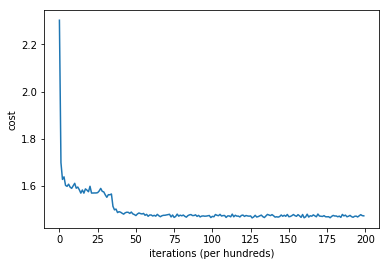

CPU times: user 22.7 s, sys: 1.73 s, total: 24.4 s
Wall time: 36 s


In [15]:
%%time
costs = []
initial = 0
batch_size = 1000
alpha = 0.01
for i in range(2000):
    batch_xs, batch_ys = get_next_batch(initial, batch_size, X_train, Y_train)
    initial = 0 if initial>=33000 else initial + batch_size
    _, c = sess.run([adam_optimize, cost], feed_dict={X: batch_xs,
                                                      Y: batch_ys,
                                                      learning_rate: alpha,
                                                     })
    if (i%300==0):
        print('Iteration:', i, 'Cost', c)
    if (i%10==0):
        costs.append(c)
        
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.show()

### Accuracy calculation

In [16]:
print(sess.run(accuracy, feed_dict={X: X_train, Y:Y_train}))
print(sess.run(accuracy, feed_dict={X: X_test, Y:Y_test}))

0.984464
0.961071


In [17]:
writer = tf.summary.FileWriter("output", sess.graph)
writer.close()

In [18]:
X_test_data = pd.read_csv('test.csv').as_matrix()
X_test_data = np.multiply(X_test_data, 1.0/255.0)
print(X_test_data.shape)

(28000, 784)


In [19]:
Y_predicted = sess.run(A3, feed_dict={X:X_test_data})

In [20]:
Y_predicted = sess.run(tf.argmax(Y_predicted, 1))

In [21]:
with open('submission-v1.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['ImageId', 'Label'])
    for i in range(Y_predicted.shape[0]):
        writer.writerow([i+1, Y_predicted[i]])   

In [22]:


# sess.close()
# tf.reset_default_graph()